In [1]:
## Load in the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import tensorflow
import keras
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
%matplotlib inline

C:\local\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\local\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
columns=['seconds','mic (trachea)','abdominal movement (stretch sensor)','thorax movement (stretch sensor)']
data_test=['seconds','thorax movement (stretch sensor)','abdominal movement (stretch sensor)','mic (right of trachea)','mic 2 (left of trachea)','mic (trachea)',]

In [3]:
data = np.load('overnight_all_compressed.npz')


In [4]:
final_array=np.array([])

a = data['arr_0']
b = data['arr_1']
c = data['arr_2']
d= c[:,(0,5,2,1)]

#change the below numpy array to stack required files and perform modelling on
final_array=np.vstack([a])

Create a dataframe from the above array

In [5]:
#create a dataframe of required file to check stats
df = pd.DataFrame(final_array,columns=columns)
#change below to see stats tests for different files
#df = pd.DataFrame(d,columns=columns)

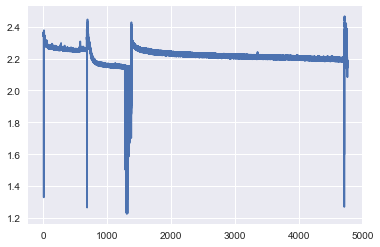

In [29]:
plt.plot(b[::,0],b[::,2])

In [ ]:
#to check loaded data correcteness by simple plots
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(b[:,0],b[:,1],label='mic (trachea)')
ax.set_ylabel('Patient Data')
ax.set_xlabel('time(in sec)')
ax.legend()

http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels 


http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python

see the adfuller test results for above data to check stationarity of the series

 As P-value is less than 0.05 which is that the series does not have a unit root and thus the series is stationary.

In [ ]:
#to see the ADFuller test results - to verify the stationarity of data
print(sm.tsa.stattools.adfuller(df['mic (trachea)'],autolag=None,maxlag=10))
print(sm.tsa.stattools.adfuller(df['abdominal movement (stretch sensor)'],autolag=None,maxlag=10))
print(sm.tsa.stattools.adfuller(df['thorax movement (stretch sensor)'],autolag=None,maxlag=10))
#output - Test static, p-value, no.of lags, no.of observations ...

#### A naive regression on above time-series to see the model results for thorax movement
X - Mic trachea
Y - Thorax Movement --> gave p-value of 0.04 indicating model fits slight closely but R - value is zero surprisingly -- need to understand this

In [6]:
df['const']=1 
model1=sm.OLS(endog=df['mic (trachea)'],exog=df[['thorax movement (stretch sensor)','const']])
results1=model1.fit()
print(results1.summary())


                            OLS Regression Results                            
Dep. Variable:          mic (trachea)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.234
Date:                Wed, 15 Aug 2018   Prob (F-statistic):             0.0396
Time:                        19:00:25   Log-Likelihood:             2.7373e+07
No. Observations:            15437778   AIC:                        -5.475e+07
Df Residuals:                15437776   BIC:                        -5.475e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
thorax m

#### A naive regression on above time-series to see the model results for abdominal movement
X - Mic trachea
Y - Abdominal Movement --> gave p-value of 0.00 and R-value is zero surprisingly 

In [14]:
df['const']=1 
model1=sm.OLS(endog=df['mic (trachea)'],exog=df[['abdominal movement (stretch sensor)','const']])
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:          mic (trachea)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09993
Date:                Mon, 20 Aug 2018   Prob (F-statistic):              0.752
Time:                        12:56:17   Log-Likelihood:                 61421.
No. Observations:               11045   AIC:                        -1.228e+05
Df Residuals:                   11043   BIC:                        -1.228e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ab

lets try differencing the abdominal stretch series data and applying Naive regeression as below -- p-value & R-value both are zero

In [15]:
df['diffS']=df['mic (trachea)'].diff() 
df['diffM']=df['abdominal movement (stretch sensor)'].diff() 
model2=sm.OLS(endog=df['diffS'].dropna(),exog=df[['diffM','const']].dropna()) 
results2=model1.fit() 
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:          mic (trachea)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09993
Date:                Mon, 20 Aug 2018   Prob (F-statistic):              0.752
Time:                        12:56:19   Log-Likelihood:                 61421.
No. Observations:               11045   AIC:                        -1.228e+05
Df Residuals:                   11043   BIC:                        -1.228e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ab

In [16]:
df['diffS']=df['mic (trachea)'].diff() 
df['diffM']=df['abdominal movement (stretch sensor)'].diff() 
model2=sm.OLS(endog=df['diffS'].dropna(),exog=df[['diffM','const']].dropna()) 
results2=model1.fit() 
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:          mic (trachea)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09993
Date:                Mon, 20 Aug 2018   Prob (F-statistic):              0.752
Time:                        12:56:31   Log-Likelihood:                 61421.
No. Observations:               11045   AIC:                        -1.228e+05
Df Residuals:                   11043   BIC:                        -1.228e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ab

In [ ]:
print(sm.tsa.stattools.grangercausalitytests(df[['mic (trachea)','abdominal movement (stretch sensor)']].dropna(),1))
print(sm.tsa.stattools.grangercausalitytests(df[['abdominal movement (stretch sensor)','mic (trachea)']].dropna(),1))
print(sm.tsa.stattools.grangercausalitytests(df[['thorax movement (stretch sensor)','mic (trachea)']].dropna(),1))
print(sm.tsa.stattools.grangercausalitytests(df[['mic (trachea)','thorax movement (stretch sensor)']].dropna(),1))

#### So from all the results above we can see that there is no causality between Mic Trachea & Thorax movement. Lets try fitting ARIMAX on abdominal movement. Before that lets index the time-series with the Datetime index.


Get the timestamp given the no.of milliseconds

In [6]:
def get_time(ml):
    milliseconds = (str)(ml % 1000)
    seconds = (int) ((ml / 1000) % 60)
    minutes = (int) ((ml / (1000*60)) % 60)
    hours   = (int) ((ml / (1000*60*60)) % 24)
    hours = "0" + (str)(hours) if(hours < 10)  else (str)(hours)
    minutes = "0" + (str)(minutes) if(minutes < 10)  else (str)(minutes)
    seconds ="0" + (str)(seconds) if (seconds < 10)  else (str)(seconds)
    
    return (' '+ hours + ":" + minutes + ":" + seconds + "." + milliseconds+"000")

#print('*********'+str(4*60*60*1000+17*60*1000+17*1000+778))
#print('**************'+ str(milliseconds))
#index=pd.date_range(start=('2018-05-05 01:00:00.000'), end=get_time(df.shape[0]), freq='1MS').tz_localize('UTC')
#index = df.between_time(start_time='2018-05-05 01:00:00.000', end_time=get_time(df.shape[0]),include_start=True,include_end=True)

In [7]:
start = '2018-05-05 00:00:00.000' # set the date for current file
#end = '2018-05-05 00:00:00.100'
end_date = start.split(' ')[0]
end =end_date+get_time(df.shape[0]-1)
times = pd.DatetimeIndex(freq='1ms', start=start, end=end) # generate timestamps to use as the indexes
df['index']=times
df =df.set_index('index') # set index to our dataframe

In [8]:
down_sample = df.resample('S')
down_sampled = down_sample.mean()


In [9]:
df = down_sampled

In [33]:
b

array([[0.000000e+00, 1.197292e+00, 2.357576e+00, 2.191535e+00],
       [1.000000e-03, 1.241303e+00, 2.353575e+00, 2.187534e+00],
       [2.000000e-03, 1.233301e+00, 2.357576e+00, 2.187534e+00],
       ...,
       [4.769864e+03, 1.345328e+00, 2.163528e+00, 2.015492e+00],
       [4.769865e+03, 1.349329e+00, 2.163528e+00, 2.017493e+00],
       [4.769866e+03, 1.353330e+00, 2.165529e+00, 2.019493e+00]])

#### Now fit the ARIMAX model for the estimation of Thorax movement given mic trachea

Before that get the Auto correlation and Partial Correlation plots to find the Parameters for ARIMA model.

In [13]:
#get a small sample to plot the correlation plots as the data is large
## we plot the first few seconds data to see where the plot first crosses the confidence interval
def get_a_sample(interval,start):
    samplingFrequency=1000
    sample = df[:][start*samplingFrequency:samplingFrequency*(start+interval)]
    return sample

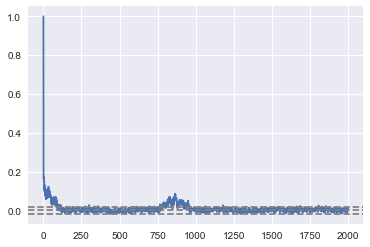

In [10]:
from statsmodels.tsa.stattools import acf, pacf
#plot ACF
ts=df['mic (trachea)']
#ts=get_a_sample(3,0)['thorax movement (stretch sensor)']
plt.plot(acf(ts, nlags=2000))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')

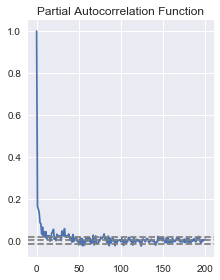

In [11]:
#Plot PACF:
plt.subplot(122)
plt.plot(pacf(ts, nlags=200, method='ols'))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### From above we get ARIMA model parametrs for (p,d,q) as below:
p=650
q=650

In [35]:
df['lag']=df['diffM'].shift()
#df.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=df['mic (trachea)'],exog=df['abdominal movement (stretch sensor)'],order=[10,1,10])
results3=model3.fit()
print(results3.summary())

C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\local\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:        D.mic (trachea)   No. Observations:                11044
Model:               ARIMA(10, 1, 10)   Log Likelihood               61955.399
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 20 Aug 2018   AIC                        -123864.799
Time:                        15:48:51   BIC                        -123696.677
Sample:                    05-05-2018   HQIC                       -123808.170
                         - 05-05-2018                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                3.231e-07   6.39e-07      0.506      0.613   -9.29e-07    1.57e-06
abdominal movement (stretch sensor) -1.397e-07   3.66e-0

C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\local\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\local\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\local\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [36]:
y_pred=model3.predict(b[::,1])

C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Below is the plot of the predicted values by our model for unseen data true values for this can be found in the beginning of the file

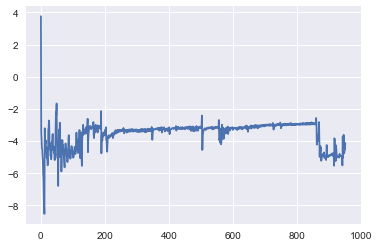

In [37]:
plt.plot(y_pred)


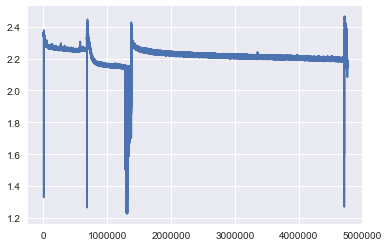

In [38]:
plt.plot(b[::,2])